# TOC:

0) Environment setup

1) Data Cleaning

2) Feature Engineering

2.1 Split Response variable

2.2 Split Input

3) Model Building 

3.1 Model 1 tf_idf+logistic regression

Break: Data Imbalance issue

3.2 Model 2: tf_idf+ SMOTE + logistic regression with filtered data

3.3 Model 3: tf_idf+ SMOTE + logistic regression with filtered data + hold-out set

3.3.1 Apply splitted input

3.4 Model 4: tf_idf+ SMOTE + XGBoost with filtered data + hold-out set

3.4.1 Apply splitted input

3.4.2 Apply Optuna Hyperparameter tuning

In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


## 0.1) Data Collection: yfinance Library

[*********************100%***********************]  1 of 1 completed

Downloaded Data:
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2020-01-02  72.796028  72.856621  71.545395  71.799881  135480400
2020-01-03  72.088303  72.851769  71.862900  72.020439  146322800
2020-01-06  72.662704  72.701485  70.953995  71.206062  118387200
2020-01-07  72.320984  72.929329  72.100426  72.672417  108872000
2020-01-08  73.484344  73.787308  72.022850  72.022850  132079200


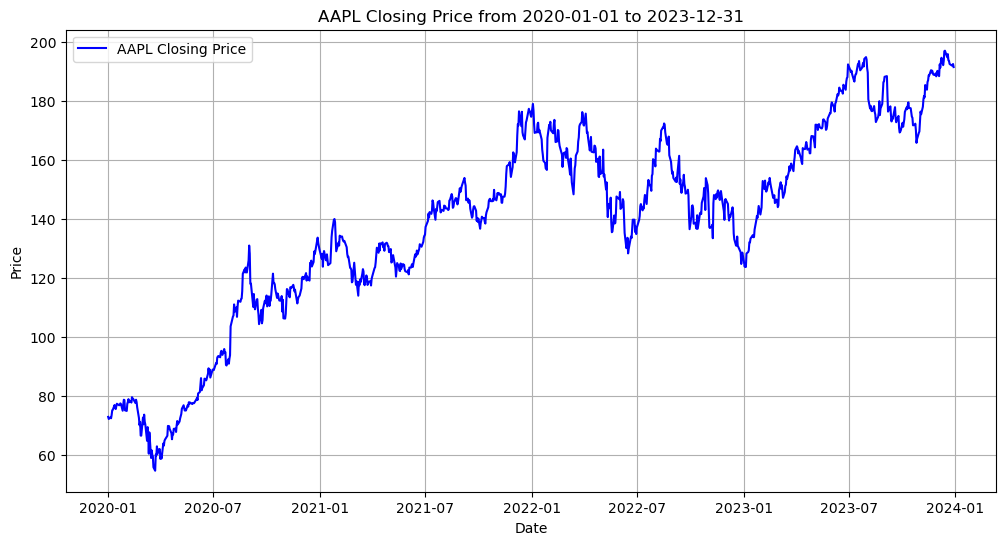

Data saved to AAPL_data.csv


In [3]:
# Import required libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Define the ticker symbol and time period
ticker_symbol = 'AAPL'  # Example: Apple Inc.
start_date = '2020-01-01'
end_date = '2023-12-31'

# Fetch historical data using yfinance
stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Display the first few rows of the data
print("Downloaded Data:")
print(stock_data.head())

# Plot the closing price
plt.figure(figsize=(12, 6))
plt.plot(stock_data['Close'], label=f'{ticker_symbol} Closing Price', color='blue')
plt.title(f'{ticker_symbol} Closing Price from {start_date} to {end_date}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

# Save the data to a CSV file for further analysis (optional)
csv_filename = f"{ticker_symbol}_data.csv"
stock_data.to_csv(csv_filename)
print(f"Data saved to {csv_filename}")

## 0.2) Data Preprecissing

In [4]:
# Include 'Date' column in the new DataFrame
new_df = pd.DataFrame({
    'Date': stock_data.index,
    'Open': stock_data['Open'].values.ravel(),
    'High': stock_data['High'].values.ravel(),
    'Low': stock_data['Low'].values.ravel(),
    'Close': stock_data['Close'].values.ravel(),
    'Volume': stock_data['Volume'].values.ravel()
})


new_df['Close']

stock_data = new_df

# Calculate daily returns
stock_data['Daily_Returns'] = stock_data['Close'].pct_change()
initial_capital = 100000  # Initial investment capital in USD


## 1) Strategy 1: Moving Average Crossover Strategy + stop-loss

### 1.1 Implement Strategy

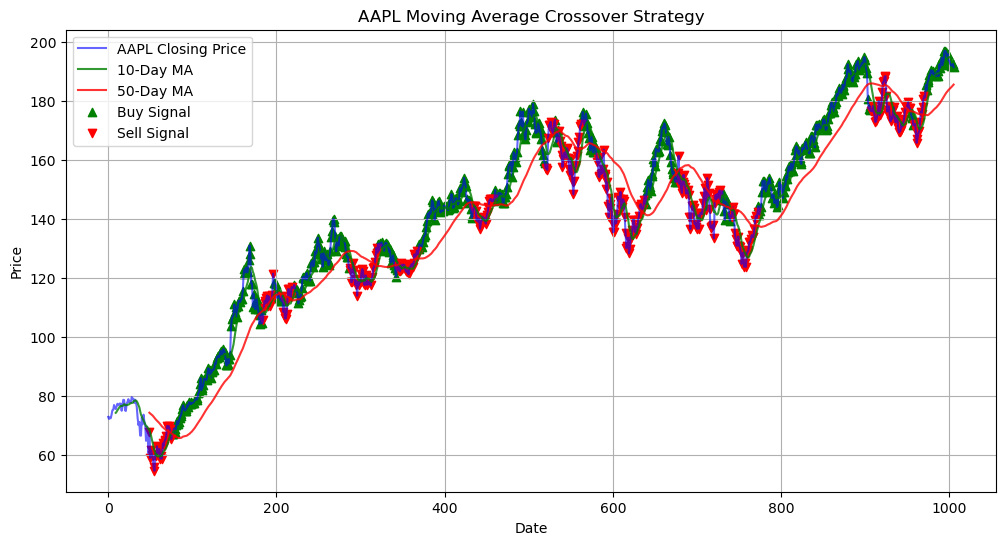

           Close    Short_MA     Long_MA  Signal
1001  192.656174  194.792705  184.403114       1
1002  192.108856  194.779770  184.690413       1
1003  192.208374  194.624530  184.982285       1
1004  192.636276  194.188664  185.313923       1
1005  191.591385  193.633385  185.650700       1


In [3]:

# Calculate moving averages
short_window = 10  # Short-term moving average (e.g., 10 days)
long_window = 50   # Long-term moving average (e.g., 50 days)

stock_data['Short_MA'] = stock_data['Close'].rolling(window=short_window).mean()
stock_data['Long_MA'] = stock_data['Close'].rolling(window=long_window).mean()

# Generate buy and sell signals
stock_data['Signal'] = 0  # Default: No signal
stock_data.loc[stock_data['Short_MA'] > stock_data['Long_MA'], 'Signal'] = 1  # Buy signal
stock_data.loc[stock_data['Short_MA'] <= stock_data['Long_MA'], 'Signal'] = -1  # Sell signal

# Plot the strategy
plt.figure(figsize=(12, 6))
plt.plot(stock_data['Close'], label=f'{ticker_symbol} Closing Price', color='blue', alpha=0.6)
plt.plot(stock_data['Short_MA'], label=f'{short_window}-Day MA', color='green', alpha=0.8)
plt.plot(stock_data['Long_MA'], label=f'{long_window}-Day MA', color='red', alpha=0.8)

# Highlight buy/sell signals
buy_signals = stock_data[stock_data['Signal'] == 1]
sell_signals = stock_data[stock_data['Signal'] == -1]
plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red', label='Sell Signal', alpha=1)

# Add chart elements
plt.title(f'{ticker_symbol} Moving Average Crossover Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

# Print sample data with signals
print(stock_data[['Close', 'Short_MA', 'Long_MA', 'Signal']].tail())

### 1.2 Backtest Strategy

0            NaN
1      -0.009722
2       0.007968
3      -0.004703
4       0.016086
          ...   
1001   -0.005547
1002   -0.002841
1003    0.000518
1004    0.002226
1005   -0.005424
Name: Daily_Returns, Length: 1006, dtype: float64
Total PnL: $37705.97
Yearly PnL: $13680.60
Sharpe Ratio: 0.89


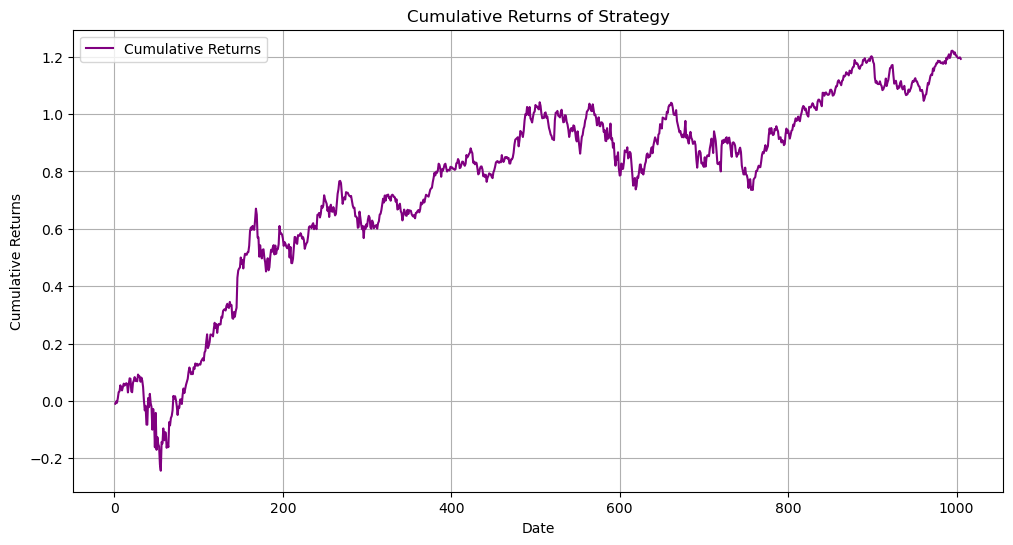

In [4]:
import numpy as np

# Parameters for risk management
stop_loss_pct = 0.05      # Stop-loss at 5% below entry price
position_size_pct = 0.02  # Risk 2% of capital per trade

# Backtest the strategy
capital = initial_capital
positions = []  # Track active positions
pnl = []  # Track daily profit and loss

for i in range(1, len(stock_data)):
    # Check signals
    if stock_data['Signal'].iloc[i] == 1:  # Check if positions list is empty
        entry_price = stock_data['Close'].iloc[i]
        risk_per_trade = capital * position_size_pct
        position_size = risk_per_trade / entry_price
        positions.append({'entry_price': entry_price, 'size': position_size})
    
    elif stock_data['Signal'].iloc[i] == -1 and len(positions) > 0:  # Check if positions list is not empty
        for position in positions:
            exit_price = stock_data['Close'].iloc[i]
            profit = (exit_price - position['entry_price']) * position['size']
            pnl.append(profit)
            capital += profit
        positions = []  # Clear positions after sell signal
    
    # Apply stop-loss
if positions:  # Ensure there are active positions
    for position in positions[:]:  # Iterate over a copy of the positions list
        entry_price = float(position['entry_price'])  # 转换为标量浮点数
        stop_loss_price = entry_price * (1 - stop_loss_pct)
        current_price = float(stock_data['Close'].iloc[i])  # 当前价格

        if current_price < stop_loss_price:  # 检查是否触发止损
            exit_price = current_price
            loss = (exit_price - entry_price) * position['size']  # 计算亏损
            pnl.append(loss)  # 保存亏损记录
            capital += loss  # 更新总资金
            positions.remove(position)  # 移除触发止损的头寸


# Calculate strategy metrics
cumulative_returns = np.cumsum(stock_data['Daily_Returns'].dropna())

sharpe_ratio = np.mean(stock_data['Daily_Returns']) / np.std(stock_data['Daily_Returns']) * np.sqrt(252)  # Annualized Sharpe Ratio
total_pnl = float(sum(pnl))
yearly_pnl = total_pnl / ((len(stock_data)) / 365)


print(f"Total PnL: ${total_pnl:.2f}")
print(f"Yearly PnL: ${yearly_pnl:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label='Cumulative Returns', color='purple')
plt.title('Cumulative Returns of Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()
plt.show()


## 2) Strategy 2: Moving Average Crossover Strategy + stop-loss + Volatility normalization

### 2.1 implement strategy

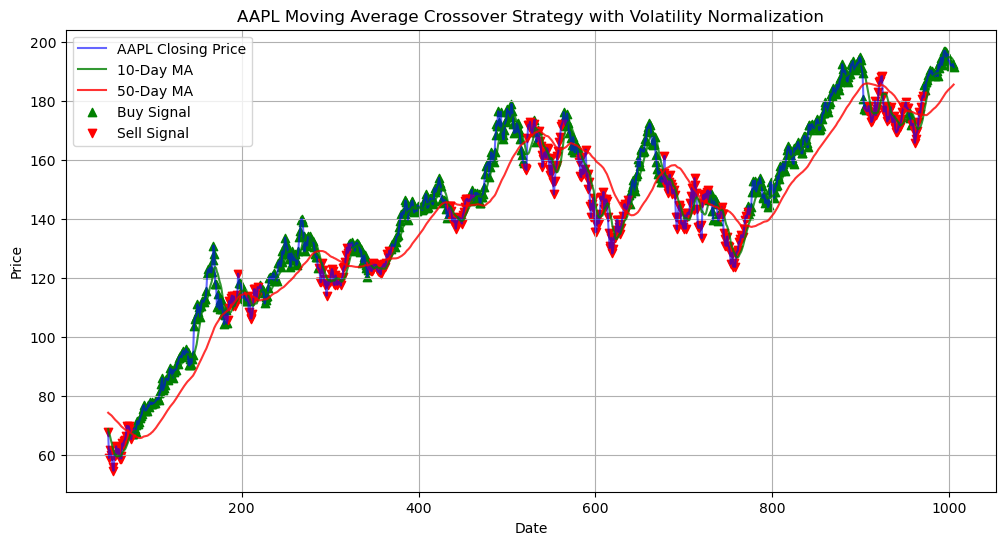

           Close    Short_MA     Long_MA  Signal  Normalized_Returns  \
1001  192.656174  194.792705  184.403116       1           -0.611524   
1002  192.108856  194.779770  184.690415       1           -0.312100   
1003  192.208359  194.624529  184.982288       1            0.057003   
1004  192.636276  194.188663  185.313925       1            0.248106   
1005  191.591400  193.633385  185.650702       1           -0.597529   

      Position_Size  
1001      -0.611524  
1002      -0.312100  
1003       0.057003  
1004       0.248106  
1005      -0.597529  


In [3]:
# Define moving averages
short_window = 10  # Short-term moving average (e.g., 10 days)
long_window = 50   # Long-term moving average (e.g., 50 days)

# Calculate moving averages
stock_data['Short_MA'] = stock_data['Close'].rolling(window=short_window).mean()
stock_data['Long_MA'] = stock_data['Close'].rolling(window=long_window).mean()

# Generate buy and sell signals
stock_data['Signal'] = 0  # Default: No signal
stock_data.loc[stock_data['Short_MA'] > stock_data['Long_MA'], 'Signal'] = 1  # Buy signal
stock_data.loc[stock_data['Short_MA'] <= stock_data['Long_MA'], 'Signal'] = -1  # Sell signal

# Calculate daily returns
stock_data['Daily_Returns'] = stock_data['Close'].pct_change()

# Calculate rolling volatility (standard deviation of returns)
volatility_window = 20  # Rolling window for volatility normalization
stock_data['Volatility'] = stock_data['Daily_Returns'].rolling(window=volatility_window).std()

# Normalize returns
stock_data['Normalized_Returns'] = stock_data['Daily_Returns'] / stock_data['Volatility']

# Calculate position size based on signals and normalized returns
stock_data['Position_Size'] = stock_data['Signal'] * stock_data['Normalized_Returns']

# Drop NaN values caused by rolling calculations
stock_data.dropna(inplace=True)

# Plot the strategy
plt.figure(figsize=(12, 6))
plt.plot(stock_data['Close'], label=f'{ticker_symbol} Closing Price', color='blue', alpha=0.6)
plt.plot(stock_data['Short_MA'], label=f'{short_window}-Day MA', color='green', alpha=0.8)
plt.plot(stock_data['Long_MA'], label=f'{long_window}-Day MA', color='red', alpha=0.8)

# Highlight buy/sell signals
buy_signals = stock_data[stock_data['Signal'] == 1]
sell_signals = stock_data[stock_data['Signal'] == -1]
plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red', label='Sell Signal', alpha=1)

# Add chart elements
plt.title(f'{ticker_symbol} Moving Average Crossover Strategy with Volatility Normalization')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

# Print sample data with signals and position size
print(stock_data[['Close', 'Short_MA', 'Long_MA', 'Signal', 'Normalized_Returns', 'Position_Size']].tail())


### 2.2 Backtest Strategy

Total PnL: $189649.60
Yearly PnL: $49939.08
Sharpe Ratio: 1.10


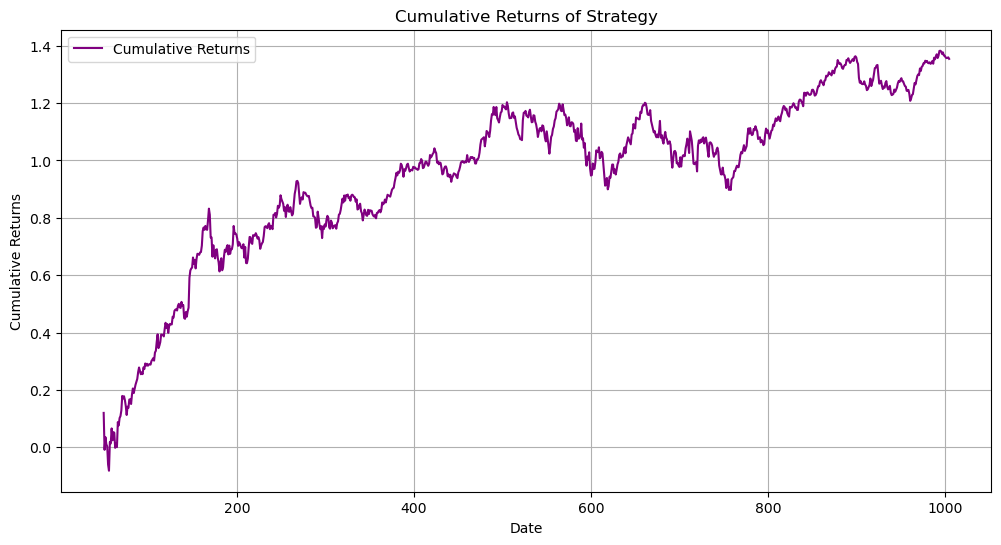

In [5]:
import numpy as np
# Parameters for risk management
initial_capital = 100000  # Initial investment capital in USD
stop_loss_pct = 0.05      # Stop-loss at 5% below entry price

# Initialize variables
capital = initial_capital
positions = []  # Track active positions
pnl = []  # Track daily profit and loss

# Backtest the strategy
for i in range(1, len(stock_data)):
    # Check buy signals
    if stock_data['Signal'].iloc[i] == 1:  # Buy signal
        entry_price = stock_data['Close'].iloc[i]
        position_size = stock_data['Position_Size'].iloc[i] * capital  # Scale position size by normalized returns
        quantity = position_size / entry_price  # Number of shares
        positions.append({'entry_price': entry_price, 'quantity': quantity})
    
    # Check sell signals
    elif stock_data['Signal'].iloc[i] == -1 and len(positions) > 0:  # Sell signal
        for position in positions:
            exit_price = stock_data['Close'].iloc[i]
            profit = (exit_price - position['entry_price']) * position['quantity']
            pnl.append(profit)
            capital += profit
        positions = []  # Clear positions after sell signal
    
    # Apply stop-loss for active positions
    if positions:  # Ensure there are active positions
        for position in positions[:]:  # Iterate over a copy of the positions list
            entry_price = position['entry_price']
            stop_loss_price = entry_price * (1 - stop_loss_pct)
            current_price = stock_data['Close'].iloc[i]

            if current_price < stop_loss_price:  # Trigger stop-loss
                exit_price = current_price
                loss = (exit_price - entry_price) * position['quantity']
                pnl.append(loss)
                capital += loss
                positions.remove(position)  # Remove the stopped-out position

# Calculate strategy metrics
cumulative_returns = np.cumsum(stock_data['Daily_Returns'].dropna())
total_pnl = float(sum(pnl))
trading_days = len(stock_data)
yearly_pnl = total_pnl / (trading_days / 252)  # Assuming 252 trading days in a year
sharpe_ratio = np.mean(stock_data['Daily_Returns']) / np.std(stock_data['Daily_Returns']) * np.sqrt(252)

# Print metrics
print(f"Total PnL: ${total_pnl:.2f}")
print(f"Yearly PnL: ${yearly_pnl:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, cumulative_returns, label='Cumulative Returns', color='purple')
plt.title('Cumulative Returns of Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()
plt.show()

### 2.3 Hyper-parameter tuning strategy

In [7]:
from sklearn.model_selection import ParameterGrid
import numpy as np

# Define the hyperparameter grid
param_grid = {
    'short_window': [5, 10, 15],
    'long_window': [30, 50, 70],
    'stop_loss_pct': [0.02, 0.05, 0.1],
    'volatility_window': [10, 20, 30]
}

# Generate all combinations of hyperparameters
grid = ParameterGrid(param_grid)

# Track results
results = []

# Backtest for each hyperparameter combination
for params in grid:
    # Extract hyperparameters
    short_window = params['short_window']
    long_window = params['long_window']
    stop_loss_pct = params['stop_loss_pct']
    volatility_window = params['volatility_window']
    
    # Apply strategy with current hyperparameters
    stock_data['Short_MA'] = stock_data['Close'].rolling(window=short_window).mean()
    stock_data['Long_MA'] = stock_data['Close'].rolling(window=long_window).mean()
    stock_data['Signal'] = 0
    stock_data.loc[stock_data['Short_MA'] > stock_data['Long_MA'], 'Signal'] = 1
    stock_data.loc[stock_data['Short_MA'] <= stock_data['Long_MA'], 'Signal'] = -1
    stock_data['Volatility'] = stock_data['Daily_Returns'].rolling(window=volatility_window).std()
    stock_data['Normalized_Returns'] = stock_data['Daily_Returns'] / stock_data['Volatility']
    stock_data['Position_Size'] = stock_data['Signal'] * stock_data['Normalized_Returns']

    # Perform backtest (reuse the backtest code here)
    capital = initial_capital
    positions = []
    pnl = []
    for i in range(1, len(stock_data)):
        if stock_data['Signal'].iloc[i] == 1:
            entry_price = stock_data['Close'].iloc[i]
            position_size = stock_data['Position_Size'].iloc[i] * capital
            quantity = position_size / entry_price
            positions.append({'entry_price': entry_price, 'quantity': quantity})
        elif stock_data['Signal'].iloc[i] == -1 and len(positions) > 0:
            for position in positions:
                exit_price = stock_data['Close'].iloc[i]
                profit = (exit_price - position['entry_price']) * position['quantity']
                pnl.append(profit)
                capital += profit
            positions = []
    
    # Calculate metrics
    total_pnl = float(sum(pnl))
    sharpe_ratio = np.mean(stock_data['Daily_Returns'].dropna()) / np.std(stock_data['Daily_Returns'].dropna()) * np.sqrt(252)

    # Store results
    results.append({
        'params': params,
        'Total PnL': total_pnl,
        'Sharpe Ratio': sharpe_ratio
    })

# Find the best combination
best_result = max(results, key=lambda x: x['Total PnL'])

# Print results
print("Best Hyperparameters:")
print(best_result['params'])
print(f"Sharpe Ratio: {best_result['Sharpe Ratio']:.2f}")
print(f"Total PnL: ${best_result['Total PnL']:.2f}")

Best Hyperparameters:
{'long_window': 30, 'short_window': 5, 'stop_loss_pct': 0.02, 'volatility_window': 10}
Sharpe Ratio: 0.89
Total PnL: $1796206.19


### 2.4 Moving average crossing + Rolling window(Prevent overfitting) + Gridsearch hyperparameter tuning + BackTest + volatility adjustment + loss-stop

In [6]:
import pandas as pd
from sklearn.model_selection import ParameterGrid
import numpy as np

# Define hyperparameter grid
param_grid = {
    'short_window': [5, 10, 15],
    'long_window': [30, 50, 70],
    'stop_loss_pct': [0.02, 0.05, 0.1],
    'volatility_window': [10, 20, 30]
}

# Generate all combinations of hyperparameters
grid = ParameterGrid(param_grid)

# Set rolling window parameters
rolling_window_size = 252  # 1 year of trading days
step_size = 21  # Monthly step size

# Store results
results = []

# Perform rolling window backtesting
for start_idx in range(0, len(stock_data) - rolling_window_size, step_size):
    # Define training and testing period
    train_data = stock_data.iloc[start_idx:start_idx + rolling_window_size].copy()
    test_data = stock_data.iloc[start_idx + rolling_window_size:start_idx + rolling_window_size + step_size].copy()

    # Evaluate each hyperparameter combination on the training data
    for params in grid:
        # Extract hyperparameters
        short_window = params['short_window']
        long_window = params['long_window']
        stop_loss_pct = params['stop_loss_pct']
        volatility_window = params['volatility_window']

        # Apply strategy on training data
        train_data['Short_MA'] = train_data['Close'].rolling(window=short_window).mean()
        train_data['Long_MA'] = train_data['Close'].rolling(window=long_window).mean()
        train_data['Signal'] = 0
        train_data.loc[train_data['Short_MA'] > train_data['Long_MA'], 'Signal'] = 1
        train_data.loc[train_data['Short_MA'] <= train_data['Long_MA'], 'Signal'] = -1
        train_data['Volatility'] = train_data['Daily_Returns'].rolling(window=volatility_window).std()
        train_data['Normalized_Returns'] = train_data['Daily_Returns'] / train_data['Volatility']
        train_data['Position_Size'] = train_data['Signal'] * train_data['Normalized_Returns']

        # Perform backtest
        capital = initial_capital
        positions = []
        pnl = []
        for i in range(1, len(train_data)):
            if train_data['Signal'].iloc[i] == 1:
                entry_price = train_data['Close'].iloc[i]
                position_size = train_data['Position_Size'].iloc[i] * capital
                quantity = position_size / entry_price
                positions.append({'entry_price': entry_price, 'quantity': quantity})
            elif train_data['Signal'].iloc[i] == -1 and len(positions) > 0:
                for position in positions:
                    exit_price = train_data['Close'].iloc[i]
                    profit = (exit_price - position['entry_price']) * position['quantity']
                    pnl.append(profit)
                    capital += profit
                positions = []

        # Calculate metrics on training data
        total_pnl = float(sum(pnl))
        sharpe_ratio = np.mean(train_data['Daily_Returns'].dropna()) / np.std(train_data['Daily_Returns'].dropna()) * np.sqrt(252)

        # Store the best parameters from training
        results.append({
            'params': params,
            'Total PnL': total_pnl,
            'Sharpe Ratio': sharpe_ratio
        })

    # Apply the best hyperparameters to test data
    best_params = max(results, key=lambda x: x['Total PnL'])['params']

    test_data['Short_MA'] = test_data['Close'].rolling(window=best_params['short_window']).mean()
    test_data['Long_MA'] = test_data['Close'].rolling(window=best_params['long_window']).mean()
    test_data['Signal'] = 0
    test_data.loc[test_data['Short_MA'] > test_data['Long_MA'], 'Signal'] = 1
    test_data.loc[test_data['Short_MA'] <= test_data['Long_MA'], 'Signal'] = -1
    test_data['Volatility'] = test_data['Daily_Returns'].rolling(window=best_params['volatility_window']).std()
    test_data['Normalized_Returns'] = test_data['Daily_Returns'] / test_data['Volatility']
    test_data['Position_Size'] = test_data['Signal'] * test_data['Normalized_Returns']

    # Perform backtest on test data (similar logic as above)

# After completing all rolling windows, analyze the aggregated results
best_overall_result = max(results, key=lambda x: x['Total PnL'])

# Print final results
print("Best Overall Hyperparameters:")
print(best_overall_result['params'])
print(f"Sharpe Ratio: {best_overall_result['Sharpe Ratio']:.2f}")
print(f"Total PnL: ${best_overall_result['Total PnL']:.2f}")

Best Overall Hyperparameters:
{'long_window': 30, 'short_window': 15, 'stop_loss_pct': 0.02, 'volatility_window': 10}
Sharpe Ratio: 1.49
Total PnL: $751150.53
